In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime

In [12]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [13]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio"]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "length1", "length2", "lumped_mass", "frequency", "x_deformation_position",
        "y_deformation_position", "z_deformation_position", "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [22]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'length1', 'length2', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [23]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [24]:
target_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(target_columns, axis=1)
y = data[target_columns]

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [26]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [29]:
scaler_y = StandardScaler()
y_train_transformed = scaler_y.fit_transform(y_train)
y_test_transformed = scaler_y.transform(y_test)

In [34]:
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [36]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6008 (pid 16784), started 1 day, 19:15:47 ago. (Use '!kill 16784' to kill it.)

In [37]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(64, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
hidden3 = Dense(16, activation='relu')(dropout2)

# Separate output for each target variable
output_allowable_deformation = Dense(1, name='allowable_deformation')(hidden3)
output_frequency = Dense(1, name='frequency')(hidden3)
output_x_position = Dense(1, name='x_deformation_position')(hidden3)
output_y_position = Dense(1, name='y_deformation_position')(hidden3)
output_z_position = Dense(1, name='z_deformation_position')(hidden3)

In [42]:
model = Model(inputs=input_layer, outputs=[output_allowable_deformation, output_frequency, 
                                           output_x_position, output_y_position, output_z_position])

In [43]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=['mse', 'mse', 'mse', 'mse', 'mse'],
              loss_weights=[1.0, 1.0, 1.0, 1.0, 1.0])

In [44]:
history = model.fit(
    x_train_transformed, 
    [y_train_transformed[:, i] for i in range(5)],  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - allowable_deformation_loss: 1.0564 - frequency_loss: 0.8067 - loss: 4.7110 - x_deformation_position_loss: 0.9221 - y_deformation_position_loss: 0.9305 - z_deformation_position_loss: 0.9952 - val_allowable_deformation_loss: 0.4946 - val_frequency_loss: 0.3882 - val_loss: 2.7999 - val_x_deformation_position_loss: 0.2490 - val_y_deformation_position_loss: 0.7138 - val_z_deformation_position_loss: 0.9409
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - allowable_deformation_loss: 0.5774 - frequency_loss: 0.4534 - loss: 3.0044 - x_deformation_position_loss: 0.3018 - y_deformation_position_loss: 0.7243 - z_deformation_position_loss: 0.9475 - val_allowable_deformation_loss: 0.1957 - val_frequency_loss: 0.2345 - val_loss: 2.0012 - val_x_deformation_position_loss: 0.1021 - val_y_deformation_position_loss: 0.5665 - val_z_deformation_position_loss: 0.8755
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - allowable_deformation_loss

In [47]:
test_acc = model.evaluate(x_test_transformed, y_test_transformed)
print('Test accuracy:', test_acc)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - allowable_deformation_loss: 1.4656 - frequency_loss: 0.0000e+00 - loss: 1.4656 - x_deformation_position_loss: 0.0000e+00 - y_deformation_position_loss: 0.0000e+00 - z_deformation_position_loss: 0.0000e+00
Test accuracy: [1.4593268632888794, 1.4598276615142822, 0.0, 0.0, 0.0, 0.0]


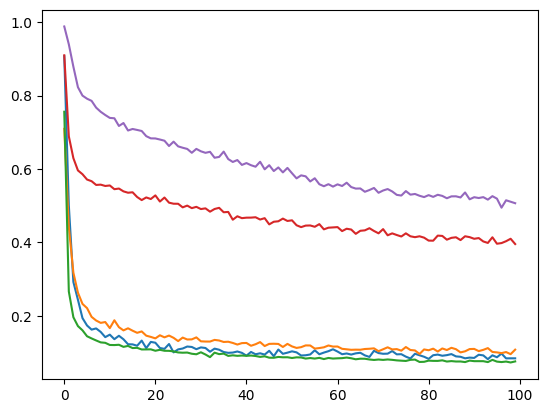

In [59]:
plt.plot(history.history['allowable_deformation_loss'])
plt.plot(history.history["frequency_loss"])
plt.plot(history.history["x_deformation_position_loss"])
plt.plot(history.history["y_deformation_position_loss"])
plt.plot(history.history["z_deformation_position_loss"])
#plt.plot(history.history["loss"])

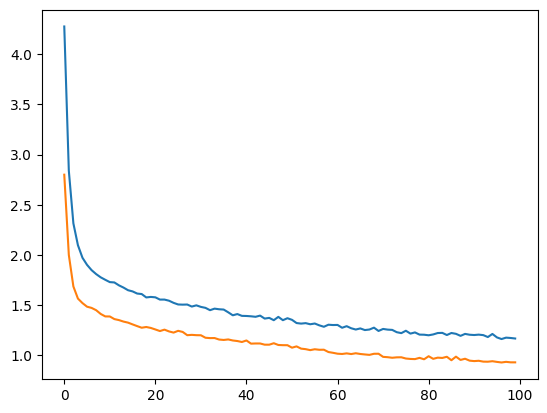

In [60]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [61]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y.inverse_transform(np.column_stack(predictions_scaled))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [65]:
predictions_df = pd.DataFrame(predictions, columns=target_columns)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
   allowable_deformation  frequency  x_deformation_position  \
0              34.905720   6.382559            -3301.449219   
1               6.631809  53.798836             -382.254700   
2              15.688627  10.719688            -2681.086670   
3               6.491465   8.968436               41.871681   
4               3.792503  11.289756             -879.281921   

   y_deformation_position  z_deformation_position  
0               44.560066                0.263669  
1               -2.901927              -28.498611  
2               39.881069               -3.598617  
3               -3.907686             -179.997086  
4                3.923813                1.835357  


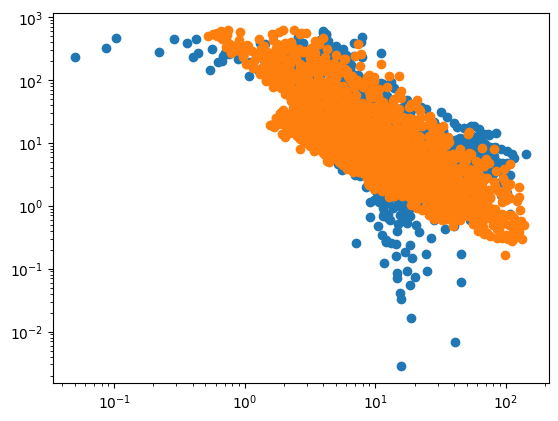

In [73]:
x=predictions_df["frequency"]
y=predictions_df["allowable_deformation"]
plt.scatter(x,y)
plt.loglog()
x=y_test["frequency"]
y=y_test["allowable_deformation"]
plt.scatter(x,y)
plt.loglog()
plt.show()

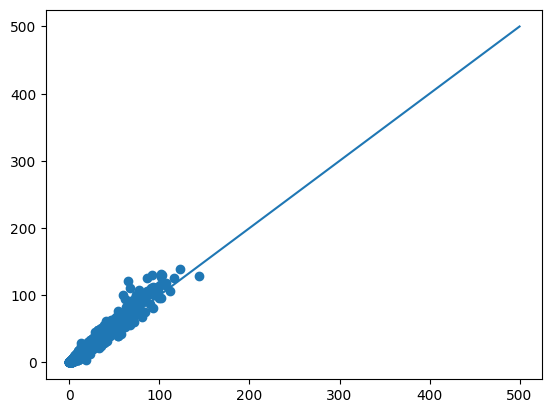

In [67]:
x=predictions_df["frequency"]
y=y_test["frequency"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 500],[0, 500])
plt.show()

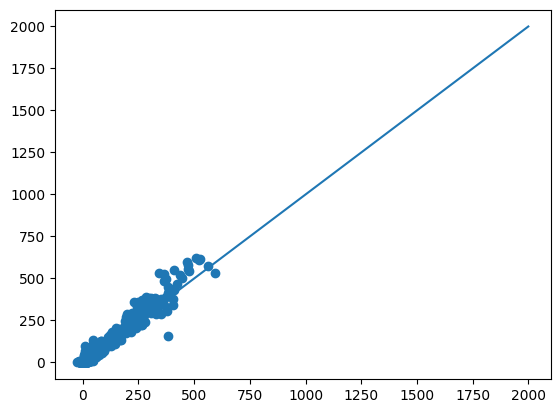

In [68]:
x=predictions_df["allowable_deformation"]
y=y_test["allowable_deformation"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 2000],[0, 2000])
plt.show()

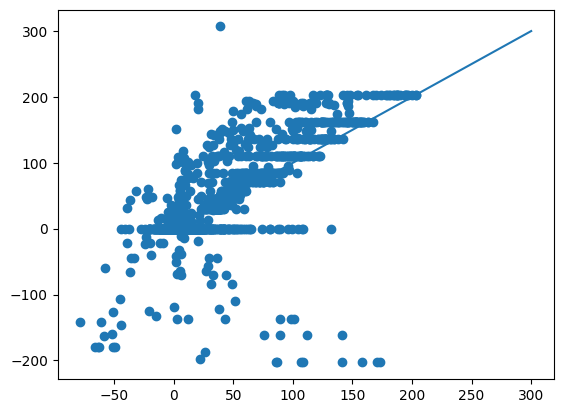

In [69]:

x=predictions_df["y_deformation_position"]
y=y_test["y_deformation_position"]
plt.scatter(x,y)
#plt.loglog()
plt.plot([0, 300],[0, 300])
plt.show()

(array([  1.,   1.,   0.,   0.,   0.,   0.,   3.,   0.,   2.,   1.,   0.,
          1.,   1.,   2.,   2.,   0.,   5.,   4.,   5.,   5.,   5.,   5.,
         16.,  24., 127., 267.,  24.,   4.,   0.,   2.]),
 array([-503.85453955, -483.93411821, -464.01369687, -444.09327553,
        -424.1728542 , -404.25243286, -384.33201152, -364.41159018,
        -344.49116884, -324.5707475 , -304.65032616, -284.72990482,
        -264.80948348, -244.88906214, -224.96864081, -205.04821947,
        -185.12779813, -165.20737679, -145.28695545, -125.36653411,
        -105.44611277,  -85.52569143,  -65.60527009,  -45.68484876,
         -25.76442742,   -5.84400608,   14.07641526,   33.9968366 ,
          53.91725794,   73.83767928,   93.75810062]),
 <BarContainer object of 30 artists>)

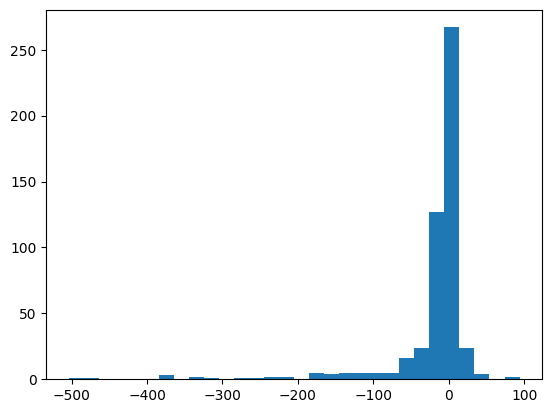

In [70]:
error= y_test["allowable_deformation"]-predictions_df["allowable_deformation"]
plt.hist(error,bins=30)